<a href="https://colab.research.google.com/github/shirleyzz/cap5610_machineleanrning/blob/master/HW3/Problem4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Build an activation model that takes as input an image and produces as output the activation of the last conv layer of the model obtained in Problem 2. Using this activation model obtain the corresponding activations for the validation images. Apply t-SNE visualization to these activations to see how well the convnet separates cats from dogs.

In [26]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-04-18 01:36:17--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   206MB/s    in 0.3s    

2019-04-18 01:36:18 (206 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
import os
import zipfile
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
#Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
#Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
#Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
#Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [0]:
img_path1 = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2020.jpg'
img_path2 = '/tmp/cats_and_dogs_filtered/validation/dogs/dog.2021.jpg'
img_path3 = '/tmp/cats_and_dogs_filtered/validation/cats/cat.2020.jpg'
img_path4 = '/tmp/cats_and_dogs_filtered/validation/cats/cat.2021.jpg'

In [30]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

# data augmentation

train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [0]:
from keras.applications import VGG19
conv_base = VGG19(
    weights='imagenet', 
    include_top=False, 
    input_shape=(150, 150, 3))
last_output = conv_base.output
conv_base.trainable = False
for layer in conv_base.layers:
  layer.trainable = False
from keras.layers import Flatten, Dense, Dropout
from keras import models
from keras import optimizers
from tensorflow.keras import Model
new = Flatten()(last_output)
new = Dense(256, activation='relu')(new)
new = Dropout(0.1)(new)
new = Dense(512,activation='relu')(new)
new = Dense(1, activation='sigmoid')(new)
# Configure and compile the model
model = models.Model(conv_base.input, new)
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.0001),
              metrics=['acc'])

In [0]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [33]:
# train
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=50)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/50
100/100 [==============================] - 20s 197ms/step - loss: 0.5741 - acc: 0.6955 - val_loss: 0.3834 - val_acc: 0.8250
Epoch 2/50
100/100 [==============================] - 19s 194ms/step - loss: 0.4794 - acc: 0.7605 - val_loss: 0.3265 - val_acc: 0.8510
Epoch 3/50
100/100 [==============================] - 18s 181ms/step - loss: 0.4451 - acc: 0.7885 - val_loss: 0.3145 - val_acc: 0.8660
Epoch 4/50
100/100 [==============================] - 18s 180ms/step - loss: 0.4096 - acc: 0.8100 - val_loss: 0.3627 - val_acc: 0.8210
Epoch 5/50
100/100 [==============================] - 18s 179ms/step - loss: 0.4018 - acc: 0.8190 - val_loss: 0.3078 - val_acc: 0.8600
Epoch 6/50
100/100 [==============================] - 19s 185ms/step - loss: 0.4002 - acc: 0.8115 - val_loss: 0.3268 - val_acc: 0.8480
Epoch 7/50
100/100 [==============================] - 18s 184ms/step - loss: 0.3877 - acc: 0.8260 - val_loss: 0.4231 - val_acc: 0.8070
Epoch 8/50
100/100 [==============================] - 1

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
layer = model.get_layer('dense_5')
layer_output = layer.output

In [38]:
activation_model = models.Model(input=model.input, outputs=[layer_output])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=Tensor("in...)`
  """Entry point for launching an IPython kernel.


In [0]:
# # activations = activation_model.predict(x_test)
# activations.shape
# activations[0]

In [0]:
activations = activation_model.predict_generator(validation_generator, steps=50)

In [0]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline
import seaborn as sns

In [0]:
def data_scatter(vecs, labels):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(labels))
    palette = np.array(sns.color_palette("husl", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(12, 12))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(vecs[:, 0], vecs[:, 1], c=palette[labels])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')


    for idx in range(num_classes):

        # Place label at median position of vectors with corresponding label

        x_coord, y_coord = np.median(vecs[labels == idx, :], axis=0)
        txt = ax.text(x_coord, y_coord, class_names[idx], fontsize=16)
        # plot class index black with white contour
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=6, foreground="w"),
            PathEffects.Normal()])

In [43]:
from sklearn.manifold import TSNE
import time
time_start = time.time()

fashion_tsne = TSNE(random_state=42).fit_transform(activations)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

t-SNE done! Time elapsed: 8.053248167037964 seconds


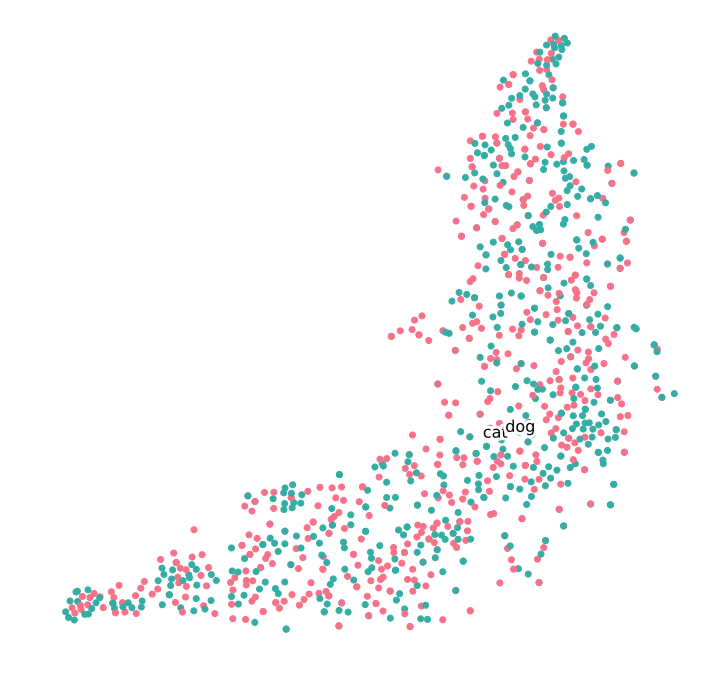

In [44]:
class_names = ['cat','dog']
labels = validation_generator.classes
np.random.shuffle(labels)
labels = labels[:1000]
data_scatter(fashion_tsne, labels)